In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Loading the datasets

from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255 # 255 as data comes in scale 0 - 255
flower = load_sample_image("flower.jpg") / 255

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# CNN filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # 7**2 filters 
filters[:, 3, :, 0] = 1 # vert
filters[3, :, :, 1] = 1 # horz

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
# we have now applied the filters using conv2d, a low level deep learning api

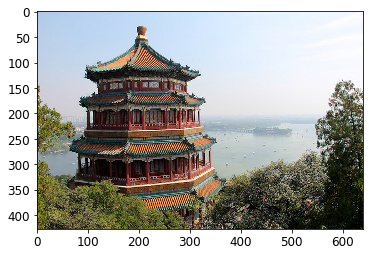

In [5]:
plt.imshow(china[:])
plt.show()

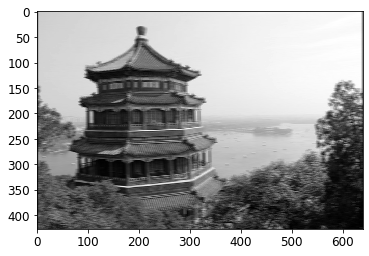

In [6]:
# printing first image's second feature map
plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.show()

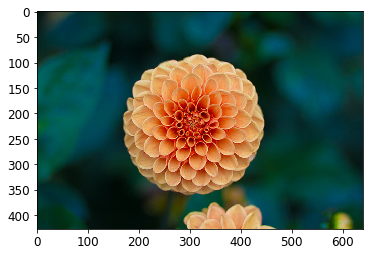

In [7]:
plt.imshow(flower[:])

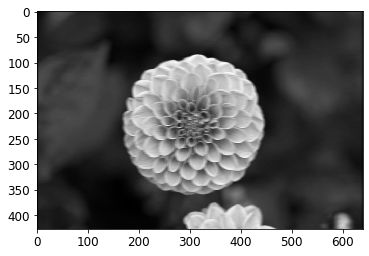

In [8]:
plt.imshow(outputs[1, :, :, 1], cmap='gray')
plt.show()

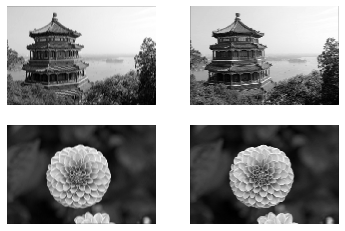

In [9]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [10]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [11]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


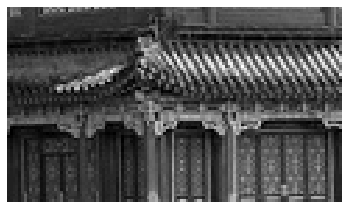

Saving figure china_vertical


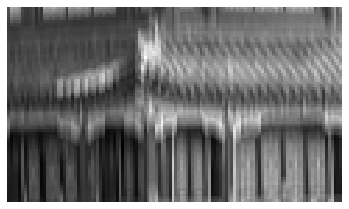

Saving figure china_horizontal


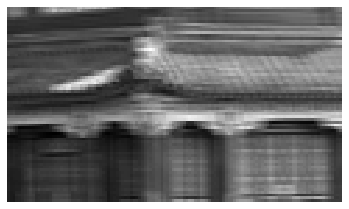

In [12]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

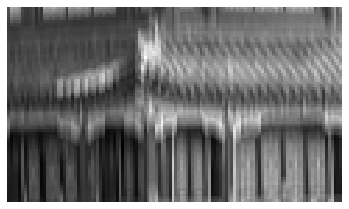

In [13]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


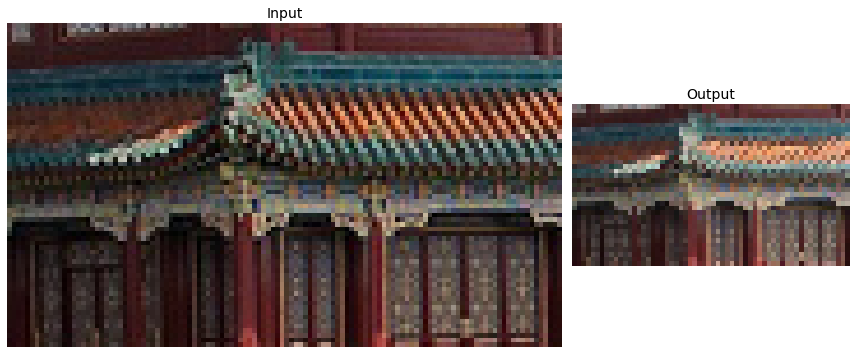

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

In [17]:
# Let us do the example of fashion MNIST with CNN's

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [18]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu',
                       padding='SAME')

In [19]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), #1=single colour
    keras.layers.MaxPooling2D(pool_size=2), # divide each spacial dimension by 2
    DefaultConv2D(filters=128),# repeat 2 times (would do more for larger images
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [20]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
             metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

# DO NOT RUN, WILL TAKE A LIFETIME!

Epoch 1/5
1719/1719 [==============================] - 231s 134ms/step - loss: 1.0255 - accuracy: 0.6401 - val_loss: 0.3854 - val_accuracy: 0.8586
Epoch 2/5
1719/1719 [==============================] - 226s 132ms/step - loss: 0.4350 - accuracy: 0.8540 - val_loss: 0.3289 - val_accuracy: 0.8744
Epoch 3/5
1719/1719 [==============================] - 225s 131ms/step - loss: 0.3683 - accuracy: 0.8762 - val_loss: 0.3281 - val_accuracy: 0.8820
Epoch 4/5
1719/1719 [==============================] - 226s 131ms/step - loss: 0.3237 - accuracy: 0.8921 - val_loss: 0.2915 - val_accuracy: 0.8954
Epoch 5/5
313/313 [==============================] - 9s 28ms/step - loss: 0.2971 - accuracy: 0.8967
